In [1]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.regularizers import l1, l2

#Required for the notebook's reproduciiility
np.random.seed(2)
tf.random.set_seed(2)

# Download latest version
path = kagglehub.dataset_download("muhammadtahir194/movies-dataset-tmdb-top-rated")

print("Path to dataset files:", path)
file_path=""
for file in os.listdir(path):
    if file.endswith(".csv"):
        file_path = os.path.join(path, file)
        break

df = pd.read_csv(file_path)
print(df.head())
df.dropna(inplace=True)
df['is_popular'] = df['popularity'] > 4.0
df['is_popular'] = df['is_popular'].astype(int) #form of one-hot encodinng

# Convert the release_date column to datetime format and extracting only the year
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year.astype(int)
df.drop(columns=['release_date'], inplace=True)

df.drop(columns=['title', 'overview'], inplace=True)
print(df.head())
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df.drop(columns=['id','popularity', 'is_popular']), df['is_popular']
print("X shape:", X.shape)
print("y shape:", y.shape)

stratify_val = y if len(np.unique(y)) < 20 else None
print("Unique y values in the dataset: ", len(np.unique(y)))

# Splitting data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=2, stratify=stratify_val)
stratify_val_temp = y_temp if stratify_val is not None else None
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2, stratify=stratify_val_temp)

print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")

# Scaling the numerical features
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

100%|██████████| 1.14M/1.14M [00:00<00:00, 1.25MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muhammadtahir194/movies-dataset-tmdb-top-rated/versions/1
        id                     title  \
0      278  The Shawshank Redemption   
1      238             The Godfather   
2      240     The Godfather Part II   
3      424          Schindler's List   
4  1356039             Counterattack   

                                            overview release_date  popularity  \
0  Imprisoned in the 1940s for the double murder ...   1994-09-23       5.522   
1  Spanning the years 1945 to 1955, a chronicle o...   1972-03-14       5.317   
2  In the continuing saga of the Corleone crime f...   1974-12-20       4.747   
3  The true story of how businessman Oskar Schind...   1993-12-15       4.457   
4  When a hostage rescue mission creates a new en...   2025-02-27       9.430   

   vote_average  vote_count  
0         8.708       27883  
1         8.689       21151  
2         8.570       12771  
3         8.567       16219  
4        

In [2]:
#Experiment nr 1
dataset_choice = 'movies'
def optimize_hyperparameter(param_name, candidate_values, best_params, build_and_train_model,
                            X_val, y_val, X_test, y_test, dataset_choice, verbose=True):
    """
    Optimize a hyperparameter based on training and validation evaluation.
    Also plot a chart comparing training and validation accuracy and loss for each candidate.

    Args:
        param_name (str): The hyperparameter to optimize (e.g., "activation", "dropout_rate").
        candidate_values (list): List of candidate values.
        best_params (dict): Current best hyperparameters.
        build_and_train_model (callable): Function that builds and trains the model.
            It must return (model, final_training_accuracy, history).
        X_val, y_val: Validation set.
        X_test, y_test: Test set.
        dataset_choice (str): Name of the dataset (for titles/logging).
        verbose (bool): If True, print intermediate results.

    Returns:
        dict: Updated best_params including the optimized parameter.
    """
    results = []          # List to store tuples: (candidate, test_acc, train_acc, train_loss, val_acc, val_loss)
    candidate_labels = [] # For plotting (string version of candidate)
    train_accs = []       # Training accuracy per candidate
    train_losses = []     # Training loss per candidate
    val_accs = []         # Validation accuracy per candidate
    val_losses = []       # Validation loss per candidate

    for candidate in candidate_values:
        # Remove the parameter to be optimized from a copy of best_params.
        params = best_params.copy()
        params.pop(param_name, None)

        # Build and train the model with the candidate value.
        # Assume build_and_train_model returns (model, train_acc, history)
        model, train_acc, history = build_and_train_model(**{param_name: candidate}, **params)
        # Retrieve the final training loss from the history
        train_loss = history.history['loss'][-1]
        # Evaluate on validation set.
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        # Also evaluate on test set (if needed for logging)
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

        if verbose:
            print(f"Candidate {candidate}: train_acc = {train_acc:.4f}, train_loss = {train_loss:.4f}, "
                  f"val_acc = {val_acc:.4f}, val_loss = {val_loss:.4f}, test_acc = {test_acc:.4f}")

        results.append((candidate, test_acc, train_acc, train_loss, val_acc, val_loss))
        candidate_labels.append(str(candidate))
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        val_accs.append(val_acc)
        val_losses.append(val_loss)

    # Create a chart with two subplots: one for accuracy and one for loss.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    x = range(len(candidate_values))
    width = 0.35  # Width for grouped bars

    # Plot training and validation accuracy.
    ax1.bar([xi - width/2 for xi in x], train_accs, width=width, label="Train Accuracy")
    ax1.bar([xi + width/2 for xi in x], val_accs, width=width, label="Val Accuracy", color='green')
    ax1.set_xticks(x)
    ax1.set_xticklabels(candidate_labels)
    ax1.set_title(f"{param_name} - Accuracy (Train vs. Val)")
    ax1.set_xlabel(param_name)
    ax1.set_ylabel("Accuracy")
    ax1.legend()

    # Plot training and validation loss.
    ax2.bar([xi - width/2 for xi in x], train_losses, width=width, label="Train Loss")
    ax2.bar([xi + width/2 for xi in x], val_losses, width=width, label="Val Loss", color='orange')
    ax2.set_xticks(x)
    ax2.set_xticklabels(candidate_labels)
    ax2.set_title(f"{param_name} - Loss (Train vs. Val)")
    ax2.set_xlabel(param_name)
    ax2.set_ylabel("Loss")
    ax2.legend()

    plt.suptitle(f"Optimization of {param_name} for {dataset_choice}")
    plt.show()

    # Choose the candidate with the highest validation accuracy.
    best_value = max(results, key=lambda x: x[4])[0]
    best_params[param_name] = best_value
    print("Temporal Best Hyperparameters:", best_params, "for dataset", dataset_choice)
    return best_params

In [3]:
import matplotlib.pyplot as plt
from keras import regularizers

def optimize_regularization(reg_candidates, best_params, build_and_train_model,
                            X_val, y_val, X_test, y_test, dataset_choice, verbose=True):
    """
    Optimize the regularization hyperparameter using training and validation evaluation,
    and plot charts comparing training vs. validation metrics for each candidate.

    Args:
        reg_candidates (list of tuples): Each tuple is (reg_id, reg_obj).
        best_params (dict): Current best hyperparameters.
        build_and_train_model (callable): Function that builds and trains the model.
            It must return (model, train_acc, history) where history.history['loss'] is available.
        X_val, y_val: Validation set.
        X_test, y_test: Test set.
        dataset_choice (str): Name of the dataset (for logging and plot titles).
        verbose (bool): If True, print intermediate results.

    Returns:
        dict: Updated best_params with the best regularizer (the actual regularizer object).
    """
    results = []          # Will store tuples: (reg_id, reg_obj, test_acc, train_acc, train_loss, val_acc, val_loss)
    candidate_labels = [] # For plotting: candidate identifiers
    train_accs = []       # Training accuracy for each candidate
    train_losses = []     # Training loss for each candidate
    val_accs = []         # Validation accuracy for each candidate
    val_losses = []       # Validation loss for each candidate

    for reg_id, reg_obj in reg_candidates:
        # Create a copy of best_params without any previous regularization.
        params = best_params.copy()
        params.pop("regularization", None)

        # Build and train the model with the current regularizer.
        model, train_acc, history = build_and_train_model(regularization=reg_obj, **params)
        train_loss = history.history['loss'][-1]

        # Evaluate on the validation set.
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        # Evaluate on the test set (for logging if desired)
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

        if verbose:
            print(f"Candidate {reg_id}: train_acc = {train_acc:.4f}, train_loss = {train_loss:.4f}, "
                  f"val_acc = {val_acc:.4f}, val_loss = {val_loss:.4f}, test_acc = {test_acc:.4f}")

        results.append((reg_id, reg_obj, test_acc, train_acc, train_loss, val_acc, val_loss))
        candidate_labels.append(reg_id)
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        val_accs.append(val_acc)
        val_losses.append(val_loss)

    # Plot a chart comparing training and validation accuracy and loss for each candidate.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    x = range(len(reg_candidates))
    width = 0.35  # Width for grouped bars

    # Plot training vs. validation accuracy.
    ax1.bar([xi - width/2 for xi in x], train_accs, width=width, label="Train Accuracy")
    ax1.bar([xi + width/2 for xi in x], val_accs, width=width, label="Val Accuracy", color='green')
    ax1.set_xticks(x)
    ax1.set_xticklabels(candidate_labels)
    ax1.set_title("Regularization: Accuracy (Train vs. Val)")
    ax1.set_xlabel("Regularization Candidate")
    ax1.set_ylabel("Accuracy")
    ax1.legend()

    # Plot training vs. validation loss.
    ax2.bar([xi - width/2 for xi in x], train_losses, width=width, label="Train Loss")
    ax2.bar([xi + width/2 for xi in x], val_losses, width=width, label="Val Loss", color='orange')
    ax2.set_xticks(x)
    ax2.set_xticklabels(candidate_labels)
    ax2.set_title("Regularization: Loss (Train vs. Val)")
    ax2.set_xlabel("Regularization Candidate")
    ax2.set_ylabel("Loss")
    ax2.legend()

    plt.suptitle(f"Optimization of Regularization for {dataset_choice}")
    plt.show()

    # Select the candidate with the highest validation accuracy.
    best_candidate = max(results, key=lambda x: x[5])  # x[5] is val_acc
    best_reg_id, best_reg_obj, _, _, _, _, _ = best_candidate
    best_params["regularization"] = best_reg_obj
    print("Temporal Best Hyperparameters:", best_params, "for dataset", dataset_choice)
    print("Selected Regularizer:", best_reg_id)
    return best_params

In [9]:
from keras.layers import LeakyReLU

def build_and_train_model(neurons=2, layers=2, activation='relu', dropout_rate=0.3, optimizer='adam',
                          learning_rate=0.001, batch_size=16, regularization=None, batch_norm=False):
    model = Sequential()

    # Input Layer
    if activation == "LeakyReLU":
        model.add(Dense(neurons, input_shape=(X_train.shape[1],), kernel_regularizer=regularization))
        model.add(LeakyReLU(alpha=0.01))  # Add LeakyReLU separately
    else:
        model.add(Dense(neurons, activation=activation, input_shape=(X_train.shape[1],),
                        kernel_regularizer=regularization))

    if batch_norm:
        model.add(BatchNormalization())

    model.add(Dropout(dropout_rate))

    # Hidden Layers
    for _ in range(layers - 1):
        if activation == "LeakyReLU":
            model.add(Dense(neurons, kernel_regularizer=regularization))
            model.add(LeakyReLU(alpha=0.01))
        else:
            model.add(Dense(neurons, activation=activation, kernel_regularizer=regularization))

        if batch_norm:
            model.add(BatchNormalization())

        model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile Model
    if optimizer == "adam":
        optimizer = keras.optimizers.Adam(learning_rate)
    elif optimizer == "rmsprop":
        optimizer = keras.optimizers.RMSprop(learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train Model
    history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)

    # Evaluate Performance
    val_acc = max(history.history['val_accuracy'])
    return model, val_acc, history



--- Order 1: ['learning_rate', 'neurons', 'batch_norm', 'activation', 'dropout_rate', 'optimizer', 'regularization', 'batch_size', 'layers'] ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Candidate 0.001: train_acc = 0.8871, train_loss = 0.3322, val_acc = 0.8801, val_loss = 0.3068, test_acc = 0.8801


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Candidate 0.01: train_acc = 0.8840, train_loss = 0.3785, val_acc = 0.8520, val_loss = 0.3534, test_acc = 0.8520


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Candidate 0.1: train_acc = 0.8723, train_loss = 43.9005, val_acc = 0.8520, val_loss = 30.6958, test_acc = 0.8520


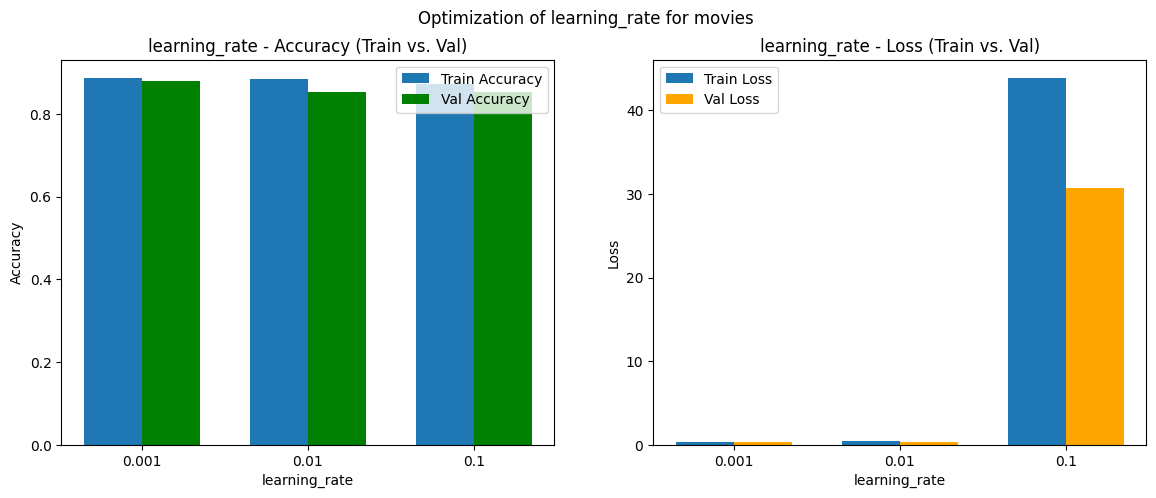

Temporal Best Hyperparameters: {'neurons': 32, 'layers': 5, 'activation': 'LeakyReLU', 'dropout_rate': 0.2, 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 16, 'regularization': <keras.src.regularizers.regularizers.L1 object at 0x7cd2e1290790>, 'batch_norm': False} for dataset movies


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Candidate 4: train_acc = 0.8520, train_loss = 0.3781, val_acc = 0.8520, val_loss = 0.3303, test_acc = 0.8520


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Candidate 8: train_acc = 0.8801, train_loss = 0.3497, val_acc = 0.8777, val_loss = 0.3121, test_acc = 0.8816


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Candidate 16: train_acc = 0.8902, train_loss = 0.3519, val_acc = 0.8863, val_loss = 0.3133, test_acc = 0.8731


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Candidate 32: train_acc = 0.8910, train_loss = 0.3346, val_acc = 0.8824, val_loss = 0.3086, test_acc = 0.8816


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Candidate 64: train_acc = 0.8925, train_loss = 0.3569, val_acc = 0.8886, val_loss = 0.3201, test_acc = 0.8746


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Candidate 128: train_acc = 0.8925, train_loss = 0.3585, val_acc = 0.8894, val_loss = 0.3197, test_acc = 0.8769


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Candidate 256: train_acc = 0.8917, train_loss = 0.3869, val_acc = 0.8879, val_loss = 0.3530, test_acc = 0.8746


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Candidate 512: train_acc = 0.8933, train_loss = 0.4744, val_acc = 0.8886, val_loss = 0.4476, test_acc = 0.8777


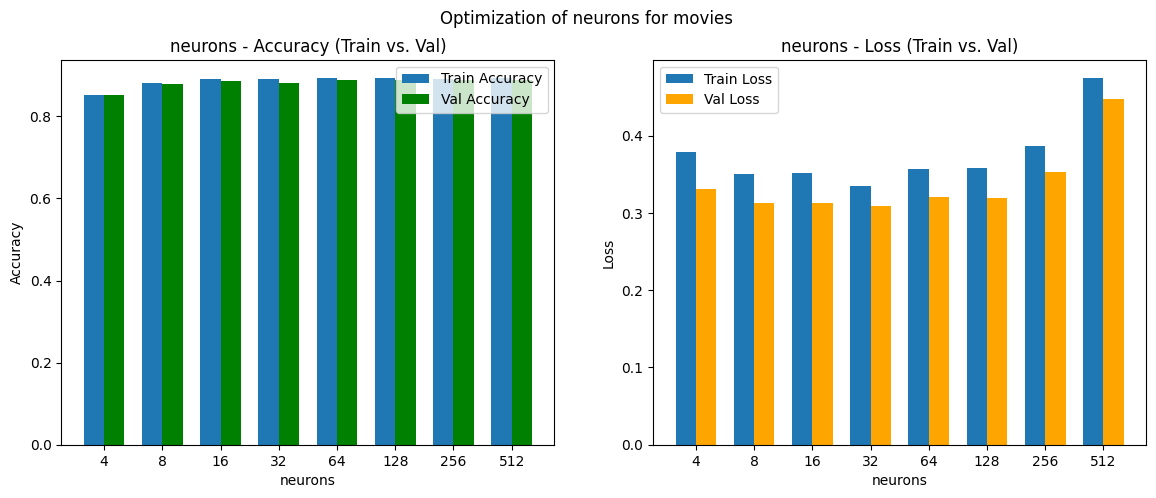

Temporal Best Hyperparameters: {'neurons': 128, 'layers': 5, 'activation': 'LeakyReLU', 'dropout_rate': 0.2, 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 16, 'regularization': <keras.src.regularizers.regularizers.L1 object at 0x7cd2e1290790>, 'batch_norm': False} for dataset movies


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Candidate False: train_acc = 0.8925, train_loss = 0.3602, val_acc = 0.8886, val_loss = 0.3285, test_acc = 0.8738


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Candidate True: train_acc = 0.8964, train_loss = 0.4073, val_acc = 0.8801, val_loss = 0.3665, test_acc = 0.8879


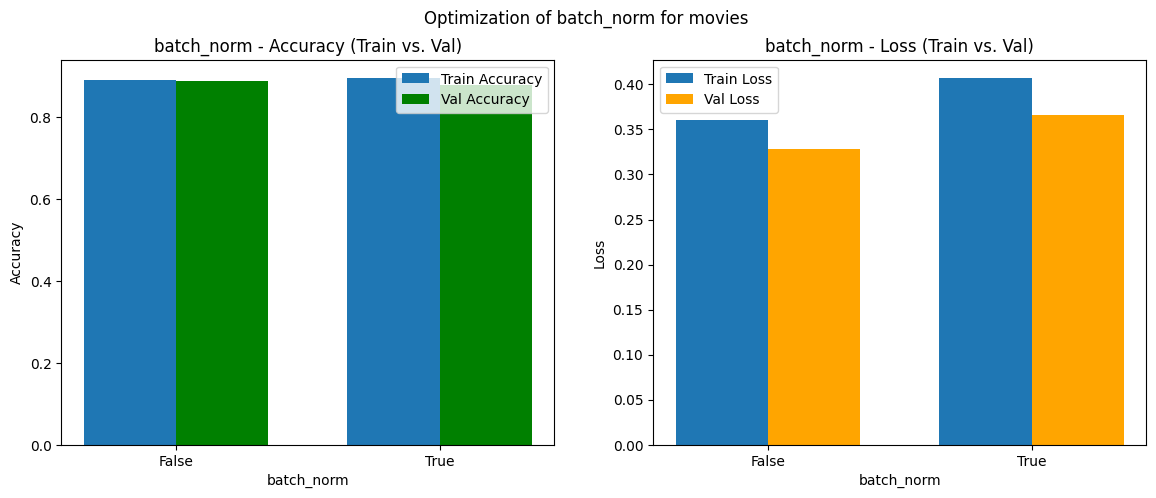

Temporal Best Hyperparameters: {'neurons': 128, 'layers': 5, 'activation': 'LeakyReLU', 'dropout_rate': 0.2, 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 16, 'regularization': <keras.src.regularizers.regularizers.L1 object at 0x7cd2e1290790>, 'batch_norm': False} for dataset movies


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Candidate relu: train_acc = 0.8917, train_loss = 0.3609, val_acc = 0.8902, val_loss = 0.3284, test_acc = 0.8738


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Candidate tanh: train_acc = 0.8917, train_loss = 0.3513, val_acc = 0.8871, val_loss = 0.3267, test_acc = 0.8785


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Candidate sigmoid: train_acc = 0.8520, train_loss = 0.4320, val_acc = 0.8520, val_loss = 0.4289, test_acc = 0.8520


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Candidate elu: train_acc = 0.8910, train_loss = 0.3477, val_acc = 0.8847, val_loss = 0.3180, test_acc = 0.8769


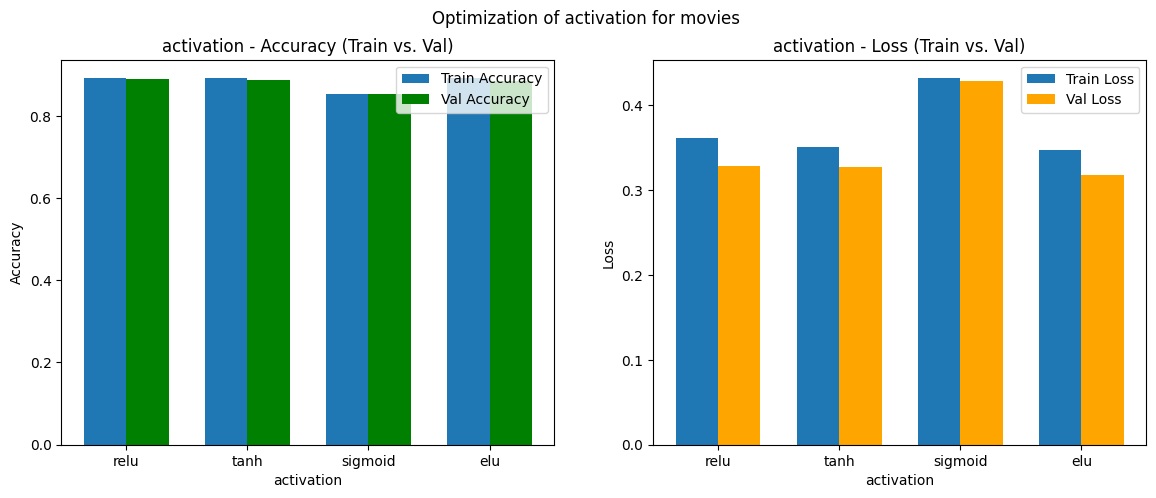

Temporal Best Hyperparameters: {'neurons': 128, 'layers': 5, 'activation': 'relu', 'dropout_rate': 0.2, 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 16, 'regularization': <keras.src.regularizers.regularizers.L1 object at 0x7cd2e1290790>, 'batch_norm': False} for dataset movies


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Candidate 0: train_acc = 0.8933, train_loss = 0.3079, val_acc = 0.8925, val_loss = 0.2860, test_acc = 0.8723


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Candidate 0.1: train_acc = 0.8917, train_loss = 0.3463, val_acc = 0.8886, val_loss = 0.3178, test_acc = 0.8731


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Candidate 0.2: train_acc = 0.8910, train_loss = 0.3572, val_acc = 0.8871, val_loss = 0.3290, test_acc = 0.8731


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Candidate 0.3: train_acc = 0.8910, train_loss = 0.3813, val_acc = 0.8816, val_loss = 0.3474, test_acc = 0.8847


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Candidate 0.4: train_acc = 0.8520, train_loss = 0.3945, val_acc = 0.8520, val_loss = 0.3560, test_acc = 0.8520


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Candidate 0.5: train_acc = 0.8520, train_loss = 0.4037, val_acc = 0.8520, val_loss = 0.3617, test_acc = 0.8520


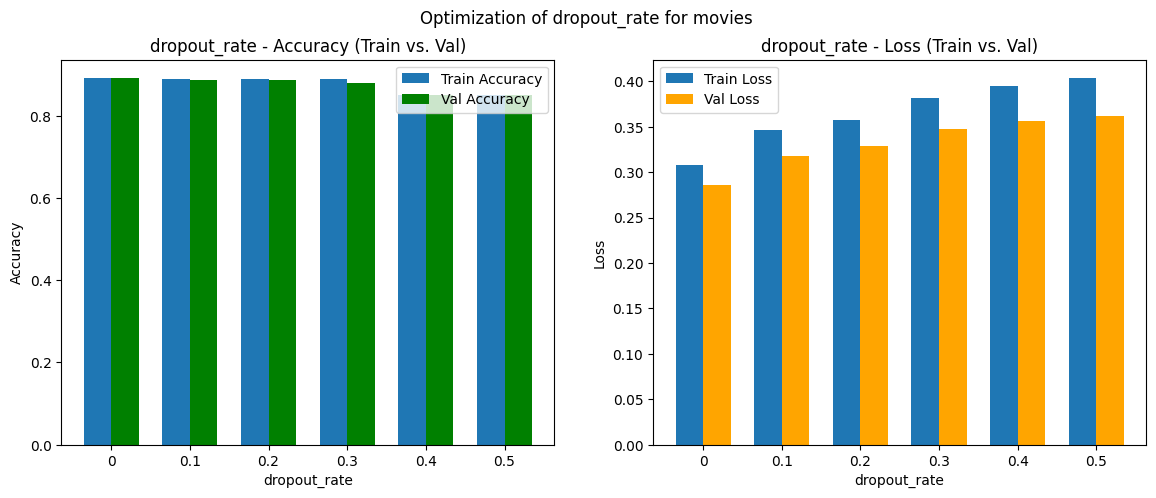

Temporal Best Hyperparameters: {'neurons': 128, 'layers': 5, 'activation': 'relu', 'dropout_rate': 0, 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 16, 'regularization': <keras.src.regularizers.regularizers.L1 object at 0x7cd2e1290790>, 'batch_norm': False} for dataset movies


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Candidate adam: train_acc = 0.8925, train_loss = 0.3098, val_acc = 0.8910, val_loss = 0.2880, test_acc = 0.8762


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Candidate rmsprop: train_acc = 0.8925, train_loss = 0.3425, val_acc = 0.8879, val_loss = 0.3154, test_acc = 0.8754


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Candidate sgd: train_acc = 0.8910, train_loss = 4.2184, val_acc = 0.8910, val_loss = 4.1899, test_acc = 0.8754


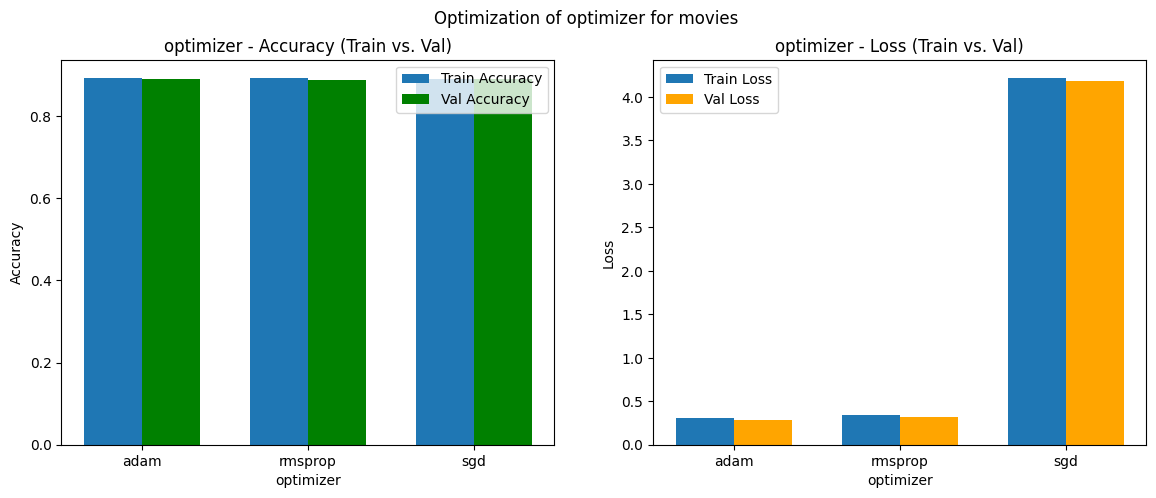

Temporal Best Hyperparameters: {'neurons': 128, 'layers': 5, 'activation': 'relu', 'dropout_rate': 0, 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 16, 'regularization': <keras.src.regularizers.regularizers.L1 object at 0x7cd2e1290790>, 'batch_norm': False} for dataset movies


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Candidate l1_0.0001: train_acc = 0.8988, train_loss = 0.2823, val_acc = 0.8941, val_loss = 0.2616, test_acc = 0.8777


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Candidate l1_0.001: train_acc = 0.8949, train_loss = 0.3093, val_acc = 0.8941, val_loss = 0.2871, test_acc = 0.8731


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Candidate l1_0.01: train_acc = 0.8520, train_loss = 0.5062, val_acc = 0.8520, val_loss = 0.5061, test_acc = 0.8520


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Candidate l1_0.1: train_acc = 0.8520, train_loss = 1.2526, val_acc = 0.8520, val_loss = 1.2549, test_acc = 0.8520


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Candidate l2_0.0001: train_acc = 0.8941, train_loss = 0.2745, val_acc = 0.8925, val_loss = 0.2530, test_acc = 0.8824


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from random import random

import random
from keras import regularizers
import matplotlib.pyplot as plt

# ------------------------------
# Assume the following are defined:
# - initial_best_params: a dictionary with the initial hyperparameters.
# - build_and_train_model: function that builds, trains, and returns (model, train_acc, history)
# - X_val, y_val: validation data.
# - X_test, y_test: test data.
# - dataset_choice: a string describing the dataset.
#
# Candidate lists for each hyperparameter:
neuron_candidates    = [4, 8, 16, 32, 64, 128, 256, 512]
layer_candidates     = [1, 2, 3, 4, 5]
activation_candidates= ["relu", "tanh", "sigmoid", "elu"]
dropout_candidates   = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
optimizer_candidates = ["adam", "rmsprop", "sgd"]
lr_candidates        = [0.001, 0.01, 0.1]
batch_size_candidates= [8, 16, 32, 64, 128]
reg_candidates       = [
    ("l1_0.0001", regularizers.l1(0.0001)),
    ("l1_0.001", regularizers.l1(0.001)),
    ("l1_0.01", regularizers.l1(0.01)),
    ("l1_0.1", regularizers.l1(0.1)),
    ("l2_0.0001", regularizers.l2(0.0001)),
    ("l2_0.001", regularizers.l2(0.001)),
    ("l2_0.01", regularizers.l2(0.01)),
    ("l2_0.1", regularizers.l2(0.1)),
    ("l1l2_0.0001", regularizers.l1_l2(l1=0.0001, l2=0.0001)),
    ("l1l2_0.001", regularizers.l1_l2(l1=0.001, l2=0.001)),
    ("l1l2_0.01", regularizers.l1_l2(l1=0.01, l2=0.01)),
    ("l1l2_0.1", regularizers.l1_l2(l1=0.1, l2=0.1)),
    ("l1_0.1_l2_0.01", regularizers.l1_l2(l1=0.1, l2=0.01)),
    ("l1_0.1_l2_0.001", regularizers.l1_l2(l1=0.1, l2=0.001)),
    ("l1_0.1_l2_0.0001", regularizers.l1_l2(l1=0.1, l2=0.0001)),
    ("l1_0.01_l2_0.1", regularizers.l1_l2(l1=0.1, l2=0.01)),
    ("l1_0.01_l2_0.001", regularizers.l1_l2(l1=0.1, l2=0.001)),
    ("l1_0.01_l2_0.0001", regularizers.l1_l2(l1=0.1, l2=0.0001)),
    ("l1_0.001_l2_0.1", regularizers.l1_l2(l1=0.1, l2=0.01)),
    ("l1_0.001_l2_0.01", regularizers.l1_l2(l1=0.1, l2=0.001)),
    ("l1_0.001_l2_0.0001", regularizers.l1_l2(l1=0.1, l2=0.0001)),
    ("l1_0.0001_l2_0.1", regularizers.l1_l2(l1=0.1, l2=0.01)),
    ("l1_0.0001_l2_0.01", regularizers.l1_l2(l1=0.1, l2=0.001)),
    ("l1_0.0001_l2_0.001", regularizers.l1_l2(l1=0.1, l2=0.0001))
]
batch_norm_candidates = [False, True]

# Assume the optimization functions are defined as:
# - optimize_hyperparameter(param_name, candidate_values, best_params, build_and_train_model,
#                            X_val, y_val, X_test, y_test, dataset_choice, verbose=True)
# - optimize_regularization(reg_candidates, best_params, build_and_train_model,
#                           X_val, y_val, X_test, y_test, dataset_choice, verbose=True)

# ------------------------------
# Automated optimization with different orders

# Define the blocks as tuples: (parameter name, candidate list, optimization function)
hyper_opt_blocks = [
    ("neurons", neuron_candidates, optimize_hyperparameter),
    ("layers", layer_candidates, optimize_hyperparameter),
    ("activation", activation_candidates, optimize_hyperparameter),
    ("dropout_rate", dropout_candidates, optimize_hyperparameter),
    ("optimizer", optimizer_candidates, optimize_hyperparameter),
    ("learning_rate", lr_candidates, optimize_hyperparameter),
    ("batch_size", batch_size_candidates, optimize_hyperparameter),
    ("regularization", reg_candidates, optimize_regularization),  # Special function for regularization
    ("batch_norm", batch_norm_candidates, optimize_hyperparameter)
]
# Number of orders to try (you could also use itertools.permutations if the list is small)
num_orders_to_try = 4
order_results = []
best_params = {'neurons': 32, 'layers': 5, 'activation': 'LeakyReLU', 'dropout_rate': 0.2, 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 16, 'regularization': regularizers.l1(0.001), 'batch_norm': False}
# Save the initial hyperparameters to be able to reset for each run.
initial_best_params = best_params.copy()

for i in range(num_orders_to_try):
    # Randomly shuffle the order of optimization blocks.
    blocks_order = hyper_opt_blocks.copy()
    random.shuffle(blocks_order)
    order_names = [block[0] for block in blocks_order]
    print(f"\n--- Order {i+1}: {order_names} ---")

    # Reset the best_params for this run.
    current_best_params = initial_best_params.copy()

    # Execute each optimization block in the chosen order.
    for (param_name, candidates, opt_func) in blocks_order:
        if param_name == "regularization":
            current_best_params = opt_func(candidates, current_best_params,
                                           build_and_train_model, X_val, y_val, X_test, y_test, dataset_choice,
                                           verbose=True)
        else:
            current_best_params = opt_func(param_name, candidates, current_best_params,
                                           build_and_train_model, X_val, y_val, X_test, y_test, dataset_choice,
                                           verbose=True)

    # After completing all blocks, build a final model and evaluate on the test set.
    final_model, _, _ = build_and_train_model(**current_best_params)
    final_test_loss, final_test_acc = final_model.evaluate(X_test, y_test, verbose=0)
    print(f"Final test accuracy for order {i+1}: {final_test_acc}")

    order_results.append((order_names, current_best_params.copy(), final_test_acc))

# ------------------------------
# Summarize the results from all orders.
best_order_result = max(order_results, key=lambda x: x[2])
best_order_names, best_hyperparams, best_final_test_acc = best_order_result

print("\n=== Final Best Hyperparameters ===")
print("The best set of hyperparameters was found using the following order of optimization:")
print(best_order_names)
print("\nBest Hyperparameters:")
for key, value in best_hyperparams.items():
    print(f"  - {key}: {value}")
print("\nFinal Test Accuracy: {:.2f}% on dataset '{}'".format(best_final_test_acc * 100, dataset_choice))

# ------------------------------
# Concluding Description and Automatic Explanation:
print("\nConclusion:")
print("After testing various orders of hyperparameter optimization, the optimal configuration was determined automatically based on validation and test performance.")
print("The best hyperparameters for the dataset '{}' are:".format(dataset_choice))
for key, value in best_hyperparams.items():
    print(f"  * {key}: {value}")
print(f"\nThis configuration achieved a final test accuracy of {best_final_test_acc*100:.2f}%.")
print("Each hyperparameter was optimized by evaluating candidate values with respect to both training and validation metrics,")
print("and the final configuration was chosen based on the best validation performance, which in turn led to the highest test accuracy.")
print("This approach helps ensure that the selected hyperparameters generalize well to unseen data.")
